# Computing and data analysis project

# Courants océaniques 

Shallow water equations (indépendantes de z) :

$$
\frac{\partial u}{\partial t}
+ u\,\frac{\partial u}{\partial x}
+ v\,\frac{\partial u}{\partial y}
+ g\,\frac{\partial \eta}{\partial x}
= \nu \nabla^{2} u
\tag{1.1}
$$

$$
\frac{\partial v}{\partial t}
+ u\,\frac{\partial v}{\partial x}
+ v\,\frac{\partial v}{\partial y}
+ g\,\frac{\partial \eta}{\partial y}
= \nu \nabla^{2} v
\tag{1.2}
$$

$$
\frac{\partial \eta}{\partial t}
+ \frac{\partial}{\partial x}\big[(H+\eta)\,u\big]
+ \frac{\partial}{\partial y}\big[(H+\eta)\,v\big]
= 0
\tag{1.3}
$$

Les différentes hypothèses pour en être arrivé à ces équations :
1. $L_h \gg L_v$ avec $L_v=H$ la profondeur de l'océan et $L_h=L$ la longueur horizontale caractéristique du domaine
2. $\Delta \rho=0$
3. $\partial_z u = \partial_z v = 0$ (on néglige la friction avec le fond et l'effet du vent)
4. L’océan possède ce que l’on appelle une surface libre, dont la variation de hauteur est notée $\eta$.

## 1D Shallow water equations :

$$
\frac{\partial u}{\partial t}
+ u\,\frac{\partial u}{\partial x}
+ g\,\frac{\partial \eta}{\partial x}
= \nu \nabla^{2} u
\tag{2.1}
$$

$$
\frac{\partial \eta}{\partial t}
+ \frac{\partial}{\partial x}\big[(H+\eta)\,u\big]
= 0
\tag{2.2}
$$

### Résolution numérique pour u

$$
\left(\frac{\partial u}{\partial x}\right)_i^k \approx \frac{u_{i+1}^k - u_{i-1}^k}{2 \Delta x}
$$

$$
\left(\frac{\partial \eta}{\partial x}\right)_i^k \approx \frac{\eta_{i+1}^k - \eta_{i-1}^k}{2 \Delta x}
$$

$$
\left(\frac{\partial^2 u}{\partial x^2}\right)_i^k \approx \frac{u_{i+1}^k - 2 u_i^k + u_{i-1}^k}{\Delta x^2}
$$

$$
\left(\frac{\partial u}{\partial t}\right)_i^k \approx \frac{u_{i}^{k+1} - u_{i}^k}{\Delta t} \Rightarrow u_{i}^{k+1} = u_{i}^k + \Delta t \left(\frac{\partial u}{\partial t}\right)_i^k
$$

$$
u_i^{k+1} = u_i^k - \Delta t \Big[ u_i^k \left(\frac{\partial u}{\partial x}\right)_i^k + g \left(\frac{\partial \eta}{\partial x}\right)_i^k - \nu \left(\frac{\partial^2 u}{\partial x^2}\right)_i^k \Big]
$$

---

### Pour eta

$$
\left(\frac{\partial \eta}{\partial t}\right)_i^k \approx \frac{\eta_{i}^{k+1} - \eta_{i}^k}{\Delta t} \Rightarrow \eta_{i}^{k+1} = \eta_{i}^k + \Delta t \left(\frac{\partial \eta}{\partial t}\right)_i^k
$$

$$
\left. \frac{\partial}{\partial x} \big[(H + \eta) u\big] \right|_i^k
\approx
\frac{ (H + \eta_{i+1}^k) u_{i+1}^k - (H + \eta_{i-1}^k) u_{i-1}^k }{ 2 \Delta x }
$$

$$
\eta_i^{k+1} = \eta_i^k - \frac{\Delta t}{2 \Delta x} \Big[ (H + \eta_{i+1}^k) u_{i+1}^k - (H + \eta_{i-1}^k) u_{i-1}^k \Big]
$$

## Conditions aux limites : 
1. $u_N=0$ (côte) même chose que $u_{N+1}=-u_N$ (paroi réfléchissante, pas de flux à travers la côte)
2. $\eta_N=\eta_{N-1}$ (côte) qui traduit $\frac{\partial \eta}{\partial x}(L,t)=0$ (paroi réfléchissante)
3. $\eta_0=\eta_1$ (océan) laisse les perturbations sortir sans réfléchir
4. $u_0=u_1$ (océan) même chose

### Condition de stabilité 

Pour un schéma explicite centré la condition est de type CFL: 
$$CFL = c \cdot \frac{\Delta t}{\Delta x} \leq 1$$ avec $c = \sqrt{gH}$. CFL : Nombre sans dimension qui compare la distance parcourue par une onde en un pas de temps avec la distance entre deux points de ta grille.

In [4]:
import numpy as np
from IPython.display import display, Math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

### Constante dans notre étude : 

In [5]:
H = 100 #m
L = 1000 #m

g  = 9.81
nu = 1e-6

**Résolution temporelle et spatiale** : 

In [6]:
N = 200
dx = L/N

Condition de stabilité :

In [7]:
c = np.sqrt(g*H)
condition = dx/c
display(Math(f"\\Delta t \\le {condition:.3f}"))

<IPython.core.display.Math object>

In [6]:
T=600
dt=0.1 #s

# Conditions initiales 

In [8]:
def gauss_1d(x, x_start, x_end, amplitude=1):
    mu = 0.5*(x_start + x_end)
    sigma = (x_end - x_start)/6.0
    return amplitude * np.exp(- (x - mu)**2 / (2 * sigma**2))

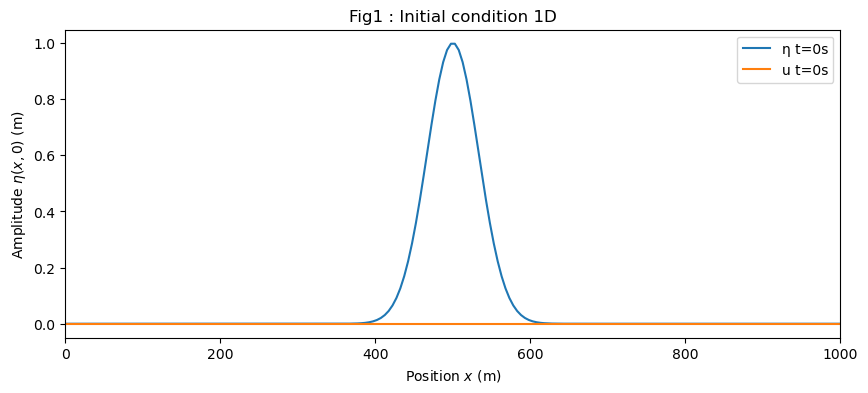

In [9]:

x= np.linspace(0,N*dx, N)

start_x = 400
end_x = 600

eta_0 = gauss_1d(x, start_x, end_x)
u_0 = np.zeros(N)

plt.figure(figsize=(10, 4))
plt.plot(x, eta_0, label="η t=0s")
plt.plot(x, u_0, label="u t=0s")
plt.xlabel("Position $x$ (m)")
plt.ylabel("Amplitude $η(x, 0)$ (m)")
plt.title("Fig1 : Initial condition 1D")
plt.legend()
plt.xlim(0, 1000) 
plt.show()

# Boucle pour résolution de l'équation

In [36]:
# initializing 
eta = np.zeros([T , N])
u  = np.zeros([T , N])

# apply initial condition
eta[0,:] = eta_0
u[0,:] = u_0

In [37]:
for k in range(T-1):
    #gauche (open ocean)
    eta[k,0] = eta[k,1]
    u[k,0]   = u[k,1]        
    # droite (côte)
    eta[k,N-1] = eta[k,N-2]
    u[k,N-1] = 0
    
    for i in range(1,N-1):
        du_dx    = (u[k,i+1] - u[k,i-1]) / (2*dx)
        deta_dx  = (eta[k,i+1] - eta[k,i-1]) / (2*dx)
        d2u_dx2  = (u[k,i+1] - 2*u[k,i] + u[k,i-1]) / (dx*dx)

        # mise à jour de u
        u[k+1,i] = u[k,i] - dt * (u[k,i]*du_dx + g*deta_dx - nu*d2u_dx2)

        # mise à jour de eta
        eta[k+1,i] = eta[k,i] - (dt / (2*dx)) * ((H + eta[k,i+1])*u[k,i+1] - (H + eta[k,i-1])*u[k,i-1])

    u[k+1,0] = u[k+1,1]
    u[k+1,N-1] = 0.0
    eta[k+1,0] = eta[k+1,1]
    eta[k+1,N-1] = eta[k+1,N-2]

C:\Users\brice\AppData\Local\Temp\ipykernel_22888\3943328660.py:18: RuntimeWarning: overflow encountered in scalar multiply
  eta[k+1,i] = eta[k,i] - (dt / (2*dx)) * ((H + eta[k,i+1])*u[k,i+1] - (H + eta[k,i-1])*u[k,i-1])
C:\Users\brice\AppData\Local\Temp\ipykernel_22888\3943328660.py:15: RuntimeWarning: overflow encountered in scalar multiply
  u[k+1,i] = u[k,i] - dt * (u[k,i]*du_dx + g*deta_dx - nu*d2u_dx2)
C:\Users\brice\AppData\Local\Temp\ipykernel_22888\3943328660.py:18: RuntimeWarning: invalid value encountered in scalar subtract
  eta[k+1,i] = eta[k,i] - (dt / (2*dx)) * ((H + eta[k,i+1])*u[k,i+1] - (H + eta[k,i-1])*u[k,i-1])
C:\Users\brice\AppData\Local\Temp\ipykernel_22888\3943328660.py:15: RuntimeWarning: invalid value encountered in scalar subtract
  u[k+1,i] = u[k,i] - dt * (u[k,i]*du_dx + g*deta_dx - nu*d2u_dx2)
C:\Users\brice\AppData\Local\Temp\ipykernel_22888\3943328660.py:12: RuntimeWarning: invalid value encountered in scalar subtract
  d2u_dx2  = (u[k,i+1] - 2*u[k,i] +

In [38]:
eta_disp = np.nan_to_num(eta, nan=0.0, posinf=0.0, neginf=0.0)
u_disp   = np.nan_to_num(u,   nan=0.0, posinf=0.0, neginf=0.0)

# =====================================================
#   PARAMÈTRES TEMPORELLE DE L’ANIMATION
# =====================================================

# Une image toutes les 0.1 s du modèle
frame_interval = 0.1
frame_step = int(frame_interval / dt)

# Liste des frames réellement affichées
frames = range(0, T, frame_step)

# FPS pour que la vidéo respecte le temps réel :
# 1 image = 0.1 s  → 10 images par seconde = temps réel
fps = int(1 / frame_interval)   # = 10


# =====================================================
#   ANIMATION DE ETA
# =====================================================

fig_eta, ax_eta = plt.subplots(figsize=(8,4))
line_eta, = ax_eta.plot([], [], color='blue')
time_text_eta = ax_eta.text(0.95, 0.9, '', transform=ax_eta.transAxes,
                            ha='right', va='top', fontsize=12)

ax_eta.set_xlim(x[0], x[-1])
ax_eta.set_ylim(np.min(eta_disp), np.max(eta_disp) + 0.5)
ax_eta.set_xlabel("x (m)")
ax_eta.set_ylabel("η (m)")

def init_eta():
    line_eta.set_data([], [])
    time_text_eta.set_text('')
    return line_eta, time_text_eta

def animate_eta(k):
    line_eta.set_data(x, eta_disp[k, :])
    t = k * dt
    time_text_eta.set_text(f"t = {t:.1f} s")
    return line_eta, time_text_eta

ani_eta = FuncAnimation(fig_eta, animate_eta, frames=frames,
                        init_func=init_eta, blit=True)

ani_eta.save("eta1.mp4", writer="ffmpeg", fps=fps)
plt.close(fig_eta)


# =====================================================
#   ANIMATION DE U
# =====================================================

fig_u, ax_u = plt.subplots(figsize=(8,4))
line_u, = ax_u.plot([], [], color='red')
time_text_u = ax_u.text(0.95, 0.9, '', transform=ax_u.transAxes,
                        ha='right', va='top', fontsize=12)

ax_u.set_xlim(x[0], x[-1])
ax_u.set_ylim(np.min(u_disp), np.max(u_disp) + 0.5)
ax_u.set_xlabel("x (m)")
ax_u.set_ylabel("u (m/s)")

def init_u():
    line_u.set_data([], [])
    time_text_u.set_text('')
    return line_u, time_text_u

def animate_u(k):
    line_u.set_data(x, u_disp[k, :])
    t = k * dt
    time_text_u.set_text(f"t = {t:.1f} s")
    return line_u, time_text_u

ani_u = FuncAnimation(fig_u, animate_u, frames=frames,
                      init_func=init_u, blit=True)

ani_u.save("u1.mp4", writer="ffmpeg", fps=fps)
plt.close(fig_u)

print("Animations sauvegardées : eta1.mp4 et u1.mp4")

Animations sauvegardées : eta1.mp4 et u1.mp4


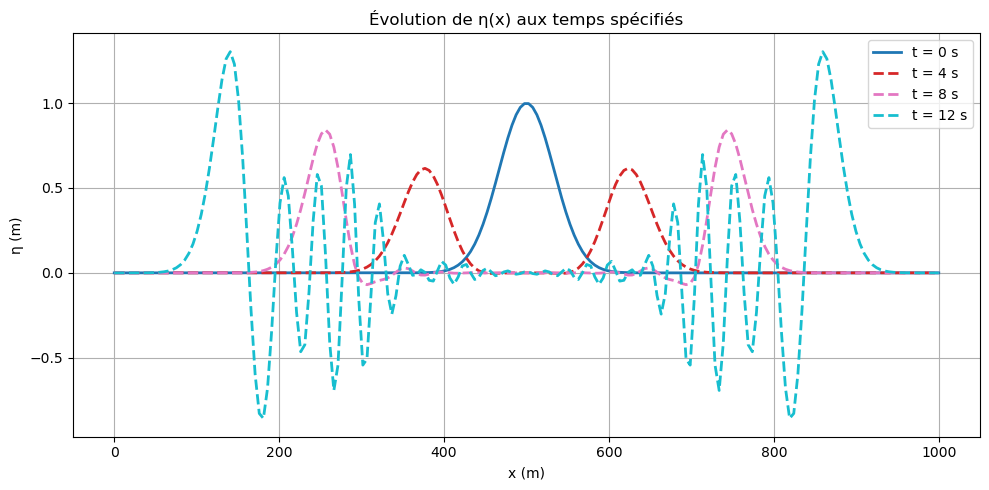

In [47]:
times_to_plot = [0, 4, 8, 12] 

# Remplacement NaN / Inf pour affichage
eta_disp = np.nan_to_num(eta, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(10,5))
colors = plt.cm.tab10(np.linspace(0, 1, len(times_to_plot)))
for t_plot, col in zip(times_to_plot, colors):
    k = int(t_plot / dt)
    if k >= T:
        print(f"⚠️  Temps t={t_plot} s ignoré (hors simulation)")
        continue
    style = '-' if t_plot == 0 else '--'
    plt.plot(x, eta_disp[k, :],color=col,linestyle=style,linewidth=2,label=f"t = {t_plot:.0f} s")
plt.xlabel("x (m)")
plt.ylabel("η (m)")
plt.title("Évolution de η")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

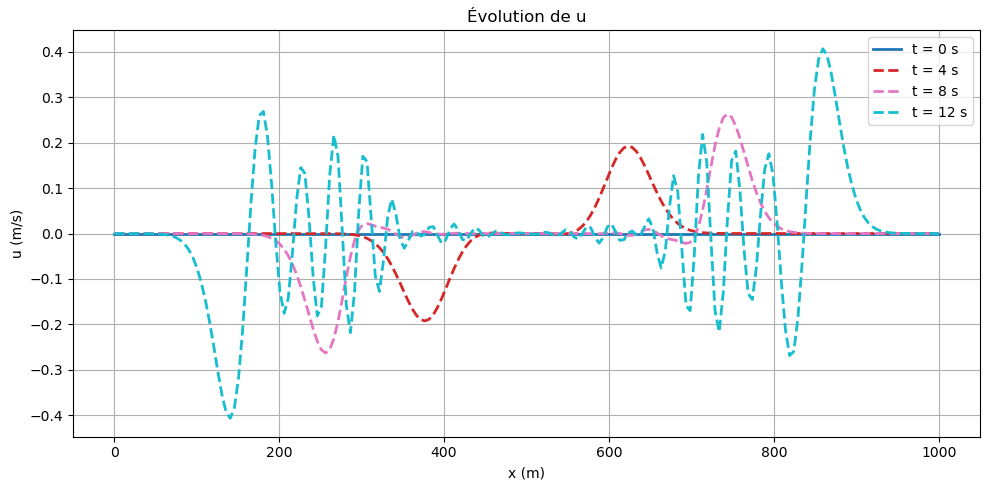

In [48]:
times_to_plot = [0, 4, 8, 12]

# Remplacement NaN / Inf pour affichage
u_disp = np.nan_to_num(u, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(10,5))
colors = plt.cm.tab10(np.linspace(0, 1, len(times_to_plot)))
for t_plot, col in zip(times_to_plot, colors):
    k = int(t_plot / dt)
    if k >= T:
        print(f"⚠️  Temps t={t_plot} s ignoré (hors simulation)")
        continue
    style = '-' if t_plot == 0 else '--'
    plt.plot(x, u_disp[k, :],
             color=col,
             linestyle=style,
             linewidth=2,
             label=f"t = {t_plot:.0f} s")
plt.xlabel("x (m)")
plt.ylabel("u (m/s)")
plt.title("Évolution de u")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

On peut voir qu'à partir du temps t=8s la stabilité comment à être compromise. Au temps t=12s la stabilité est compromise. Il faudrait donc sans doute avoir un dt plus petit, plus en marge avec la condition de stabilité CFL. 

In [10]:
T=6000
dt=0.01 #s

In [50]:
# initializing 
eta = np.zeros([T , N])
u  = np.zeros([T , N])

# apply initial condition
eta[0,:] = eta_0
u[0,:] = u_0

In [51]:
for k in range(T-1):
    #gauche (open ocean)
    eta[k,0] = eta[k,1]
    u[k,0]   = u[k,1]        
    # droite (côte)
    eta[k,N-1] = eta[k,N-2]
    u[k,N-1] = 0
    
    for i in range(1,N-1):
        du_dx    = (u[k,i+1] - u[k,i-1]) / (2*dx)
        deta_dx  = (eta[k,i+1] - eta[k,i-1]) / (2*dx)
        d2u_dx2  = (u[k,i+1] - 2*u[k,i] + u[k,i-1]) / (dx*dx)

        # mise à jour de u
        u[k+1,i] = u[k,i] - dt * (u[k,i]*du_dx + g*deta_dx - nu*d2u_dx2)

        # mise à jour de eta
        eta[k+1,i] = eta[k,i] - (dt / (2*dx)) * ((H + eta[k,i+1])*u[k,i+1] - (H + eta[k,i-1])*u[k,i-1])

    u[k+1,0] = u[k+1,1]
    u[k+1,N-1] = 0.0
    eta[k+1,0] = eta[k+1,1]
    eta[k+1,N-1] = eta[k+1,N-2]

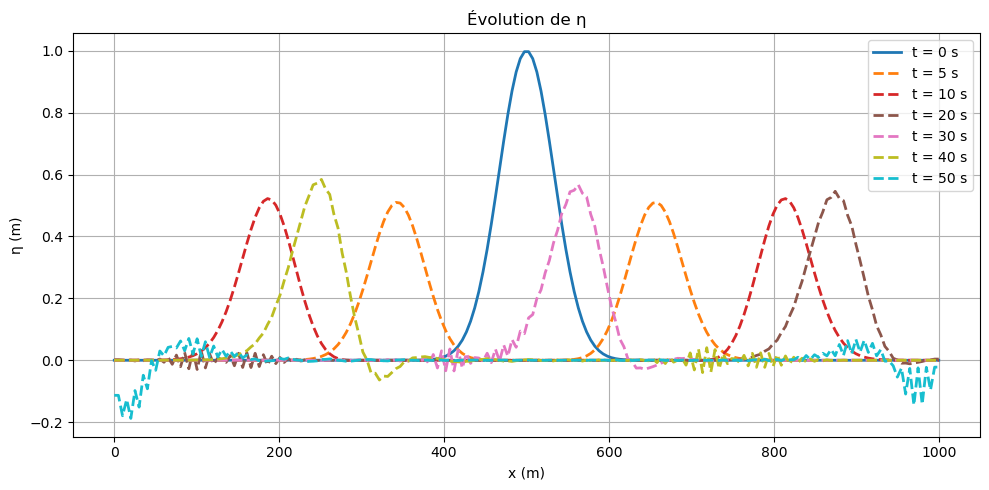

In [53]:
times_to_plot = [0, 5, 10, 20, 30, 40, 50] 

# Remplacement NaN / Inf pour affichage
eta_disp = np.nan_to_num(eta, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(10,5))
colors = plt.cm.tab10(np.linspace(0, 1, len(times_to_plot)))

for t_plot, col in zip(times_to_plot, colors):
    k = int(t_plot / dt)
    if k >= T:
        print(f"⚠️  Temps t={t_plot} s ignoré (hors simulation)")
        continue
    style = '-' if t_plot == 0 else '--'
    plt.plot(x, eta_disp[k, :],
             color=col,
             linestyle=style,
             linewidth=2,
             label=f"t = {t_plot:.0f} s")
plt.xlabel("x (m)")
plt.ylabel("η (m)")
plt.title("Évolution de η")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

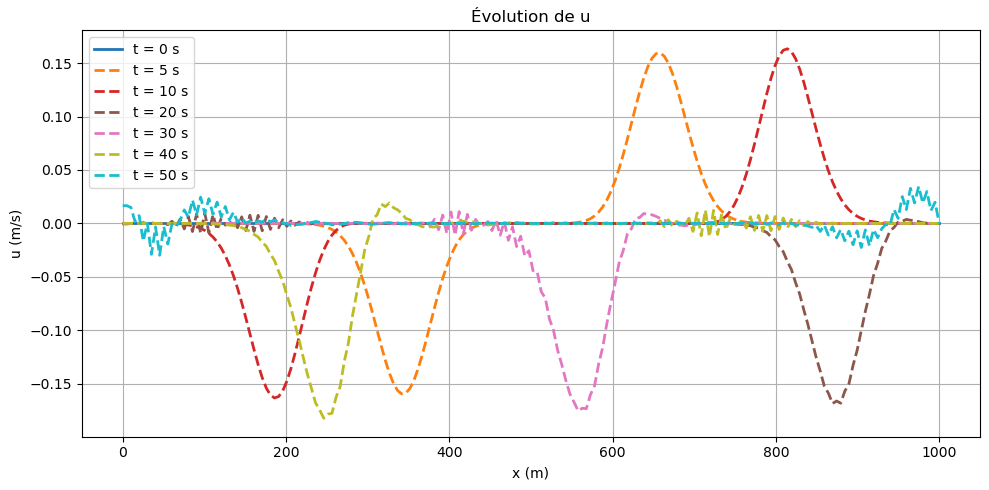

In [55]:
times_to_plot = [0, 5, 10, 20, 30, 40, 50] 

# Remplacement NaN / Inf pour affichage
u_disp = np.nan_to_num(u, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(10,5))
colors = plt.cm.tab10(np.linspace(0, 1, len(times_to_plot)))
for t_plot, col in zip(times_to_plot, colors):
    k = int(t_plot / dt)
    if k >= T:
        print(f"⚠️  Temps t={t_plot} s ignoré (hors simulation)")
        continue
    style = '-' if t_plot == 0 else '--'
    plt.plot(x, u_disp[k, :],
             color=col,
             linestyle=style,
             linewidth=2,
             label=f"t = {t_plot:.0f} s")
plt.xlabel("x (m)")
plt.ylabel("u (m/s)")
plt.title("Évolution de u")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

On voit ici que la condition au bord à gauche (open ocean) implique une petite perturbation qui se propage ensuite. Ou alors c'est plutôt le terme non linéaire / terme visqueux qui implique cette perturbation ? Regarder dans le cas ou on néglige l'un des deux et les deux. 

# Sans terme non linéaire 

In [11]:
# initializing 
eta = np.zeros([T , N])
u  = np.zeros([T , N])

# apply initial condition
eta[0,:] = eta_0
u[0,:] = u_0

In [12]:
for k in range(T-1):
    #gauche (open ocean)
    eta[k,0] = eta[k,1]
    u[k,0]   = u[k,1]        
    # droite (côte)
    eta[k,N-1] = eta[k,N-2]
    u[k,N-1] = 0
    
    for i in range(1,N-1):
        du_dx    = (u[k,i+1] - u[k,i-1]) / (2*dx)
        deta_dx  = (eta[k,i+1] - eta[k,i-1]) / (2*dx)
        d2u_dx2  = (u[k,i+1] - 2*u[k,i] + u[k,i-1]) / (dx*dx)

        # mise à jour de u
        u[k+1,i] = u[k,i] - dt * (g*deta_dx - nu*d2u_dx2)

        # mise à jour de eta
        eta[k+1,i] = eta[k,i] - (dt / (2*dx)) * ((H + eta[k,i+1])*u[k,i+1] - (H + eta[k,i-1])*u[k,i-1])

    u[k+1,0] = u[k+1,1]
    u[k+1,N-1] = 0.0
    eta[k+1,0] = eta[k+1,1]
    eta[k+1,N-1] = eta[k+1,N-2]

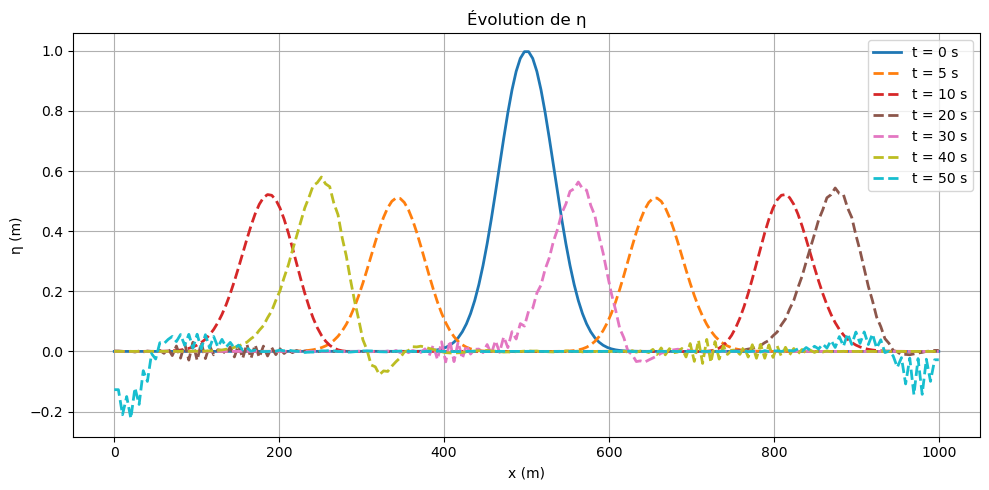

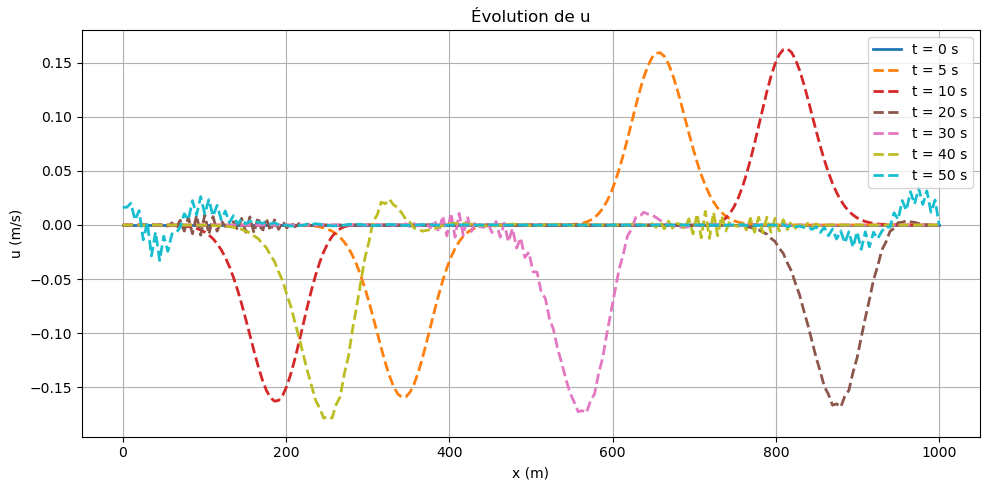

In [13]:
times_to_plot = [0, 5, 10, 20, 30, 40, 50] 

# Remplacement NaN / Inf pour affichage
eta_disp = np.nan_to_num(eta, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(10,5))
colors = plt.cm.tab10(np.linspace(0, 1, len(times_to_plot)))

for t_plot, col in zip(times_to_plot, colors):
    k = int(t_plot / dt)
    if k >= T:
        print(f"⚠️  Temps t={t_plot} s ignoré (hors simulation)")
        continue
    style = '-' if t_plot == 0 else '--'
    plt.plot(x, eta_disp[k, :],
             color=col,
             linestyle=style,
             linewidth=2,
             label=f"t = {t_plot:.0f} s")
plt.xlabel("x (m)")
plt.ylabel("η (m)")
plt.title("Évolution de η")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Remplacement NaN / Inf pour affichage
u_disp = np.nan_to_num(u, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(10,5))
colors = plt.cm.tab10(np.linspace(0, 1, len(times_to_plot)))
for t_plot, col in zip(times_to_plot, colors):
    k = int(t_plot / dt)
    if k >= T:
        print(f"⚠️  Temps t={t_plot} s ignoré (hors simulation)")
        continue
    style = '-' if t_plot == 0 else '--'
    plt.plot(x, u_disp[k, :],
             color=col,
             linestyle=style,
             linewidth=2,
             label=f"t = {t_plot:.0f} s")
plt.xlabel("x (m)")
plt.ylabel("u (m/s)")
plt.title("Évolution de u")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Sans terme visqueux 

In [14]:
# initializing 
eta = np.zeros([T , N])
u  = np.zeros([T , N])

# apply initial condition
eta[0,:] = eta_0
u[0,:] = u_0

In [16]:
for k in range(T-1):
    #gauche (open ocean)
    eta[k,0] = eta[k,1]
    u[k,0]   = u[k,1]        
    # droite (côte)
    eta[k,N-1] = eta[k,N-2]
    u[k,N-1] = 0
    
    for i in range(1,N-1):
        du_dx    = (u[k,i+1] - u[k,i-1]) / (2*dx)
        deta_dx  = (eta[k,i+1] - eta[k,i-1]) / (2*dx)

        # mise à jour de u
        u[k+1,i] = u[k,i] - dt * (u[k,i]*du_dx + g*deta_dx)

        # mise à jour de eta
        eta[k+1,i] = eta[k,i] - (dt / (2*dx)) * ((H + eta[k,i+1])*u[k,i+1] - (H + eta[k,i-1])*u[k,i-1])

    u[k+1,0] = u[k+1,1]
    u[k+1,N-1] = 0.0
    eta[k+1,0] = eta[k+1,1]
    eta[k+1,N-1] = eta[k+1,N-2]

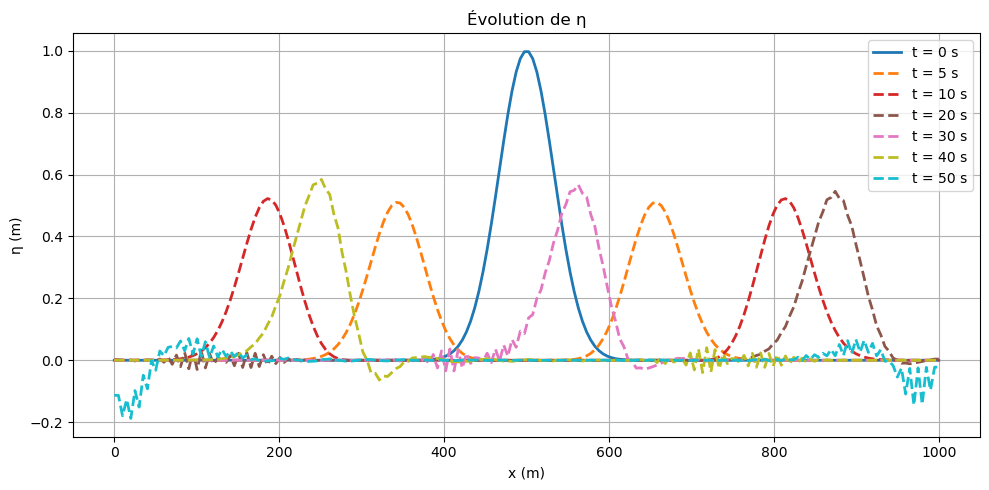

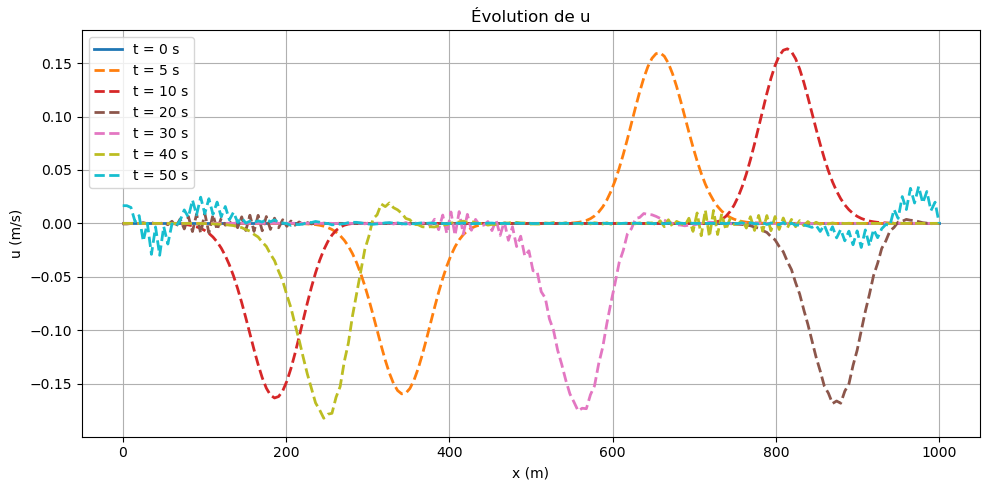

In [17]:
times_to_plot = [0, 5, 10, 20, 30, 40, 50] 

# Remplacement NaN / Inf pour affichage
eta_disp = np.nan_to_num(eta, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(10,5))
colors = plt.cm.tab10(np.linspace(0, 1, len(times_to_plot)))

for t_plot, col in zip(times_to_plot, colors):
    k = int(t_plot / dt)
    if k >= T:
        print(f"⚠️  Temps t={t_plot} s ignoré (hors simulation)")
        continue
    style = '-' if t_plot == 0 else '--'
    plt.plot(x, eta_disp[k, :],
             color=col,
             linestyle=style,
             linewidth=2,
             label=f"t = {t_plot:.0f} s")
plt.xlabel("x (m)")
plt.ylabel("η (m)")
plt.title("Évolution de η")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Remplacement NaN / Inf pour affichage
u_disp = np.nan_to_num(u, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(10,5))
colors = plt.cm.tab10(np.linspace(0, 1, len(times_to_plot)))
for t_plot, col in zip(times_to_plot, colors):
    k = int(t_plot / dt)
    if k >= T:
        print(f"⚠️  Temps t={t_plot} s ignoré (hors simulation)")
        continue
    style = '-' if t_plot == 0 else '--'
    plt.plot(x, u_disp[k, :],
             color=col,
             linestyle=style,
             linewidth=2,
             label=f"t = {t_plot:.0f} s")
plt.xlabel("x (m)")
plt.ylabel("u (m/s)")
plt.title("Évolution de u")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Sans les deux 

In [20]:
# initializing 
eta = np.zeros([T , N])
u  = np.zeros([T , N])

# apply initial condition
eta[0,:] = eta_0
u[0,:] = u_0

In [21]:
for k in range(T-1):
    for i in range(1,N-1):
        du_dx    = (u[k,i+1] - u[k,i-1]) / (2*dx)
        deta_dx  = (eta[k,i+1] - eta[k,i-1]) / (2*dx)

        # mise à jour de u
        u[k+1,i] = u[k,i] - dt * (g*deta_dx)

        # mise à jour de eta
        eta[k+1,i] = eta[k,i] - (dt / (2*dx)) * ((H + eta[k,i+1])*u[k,i+1] - (H + eta[k,i-1])*u[k,i-1])

    u[k+1,0] = u[k+1,1]
    u[k+1,N-1] = 0.0
    eta[k+1,0] = eta[k+1,1]
    eta[k+1,N-1] = eta[k+1,N-2]

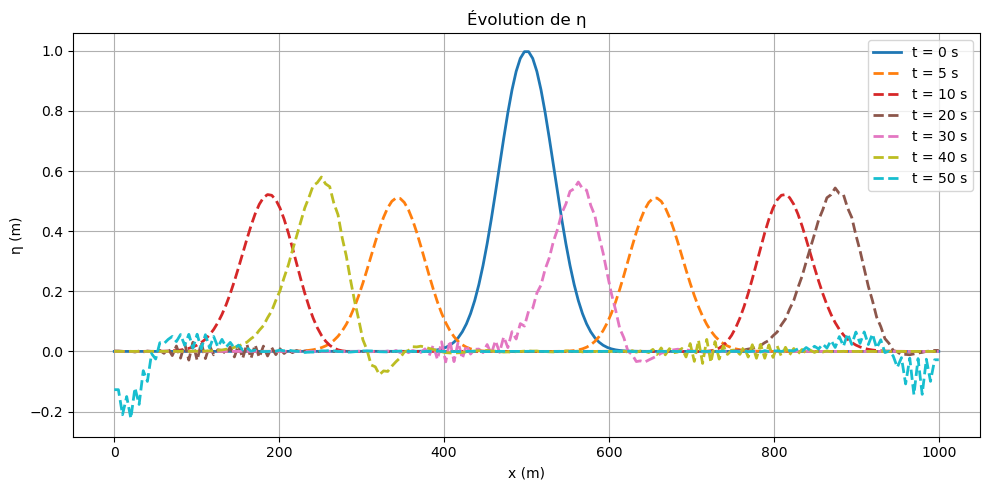

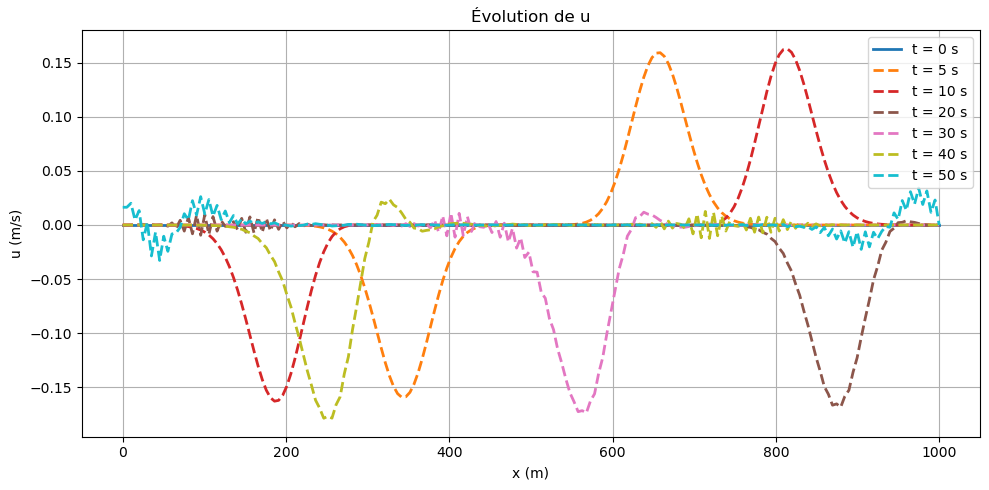

In [22]:
times_to_plot = [0, 5, 10, 20, 30, 40, 50] 

# Remplacement NaN / Inf pour affichage
eta_disp = np.nan_to_num(eta, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(10,5))
colors = plt.cm.tab10(np.linspace(0, 1, len(times_to_plot)))

for t_plot, col in zip(times_to_plot, colors):
    k = int(t_plot / dt)
    if k >= T:
        print(f"⚠️  Temps t={t_plot} s ignoré (hors simulation)")
        continue
    style = '-' if t_plot == 0 else '--'
    plt.plot(x, eta_disp[k, :],
             color=col,
             linestyle=style,
             linewidth=2,
             label=f"t = {t_plot:.0f} s")
plt.xlabel("x (m)")
plt.ylabel("η (m)")
plt.title("Évolution de η")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Remplacement NaN / Inf pour affichage
u_disp = np.nan_to_num(u, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(10,5))
colors = plt.cm.tab10(np.linspace(0, 1, len(times_to_plot)))
for t_plot, col in zip(times_to_plot, colors):
    k = int(t_plot / dt)
    if k >= T:
        print(f"⚠️  Temps t={t_plot} s ignoré (hors simulation)")
        continue
    style = '-' if t_plot == 0 else '--'
    plt.plot(x, u_disp[k, :],
             color=col,
             linestyle=style,
             linewidth=2,
             label=f"t = {t_plot:.0f} s")
plt.xlabel("x (m)")
plt.ylabel("u (m/s)")
plt.title("Évolution de u")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

C'est peut-être alors tout simplement une question de stabilité ?

# dt=0.001

In [25]:
T=60000
dt=0.001

In [26]:
# initializing 
eta = np.zeros([T , N])
u  = np.zeros([T , N])

# apply initial condition
eta[0,:] = eta_0
u[0,:] = u_0

In [27]:
for k in range(T-1):
    for i in range(1,N-1):
        du_dx    = (u[k,i+1] - u[k,i-1]) / (2*dx)
        deta_dx  = (eta[k,i+1] - eta[k,i-1]) / (2*dx)

        # mise à jour de u
        u[k+1,i] = u[k,i] - dt * (g*deta_dx)

        # mise à jour de eta
        eta[k+1,i] = eta[k,i] - (dt / (2*dx)) * ((H + eta[k,i+1])*u[k,i+1] - (H + eta[k,i-1])*u[k,i-1])

    u[k+1,0] = u[k+1,1]
    u[k+1,N-1] = 0.0
    eta[k+1,0] = eta[k+1,1]
    eta[k+1,N-1] = eta[k+1,N-2]

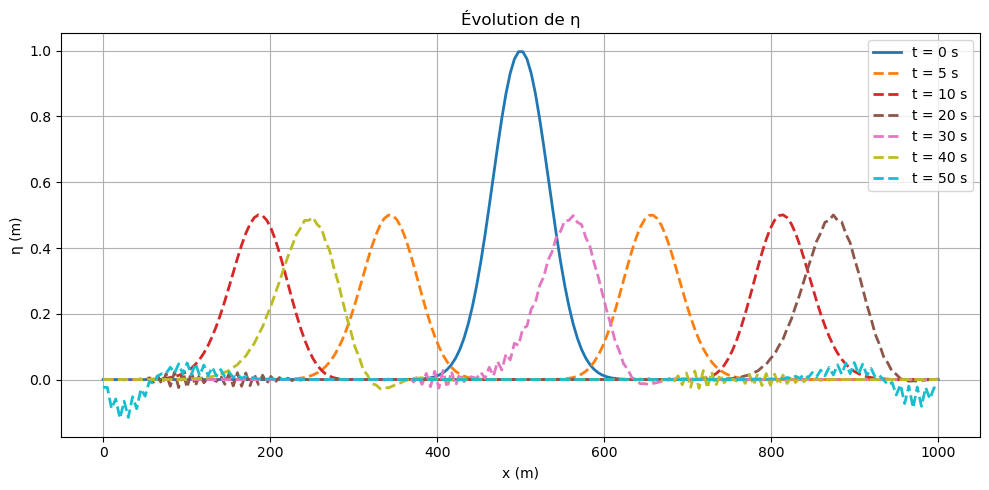

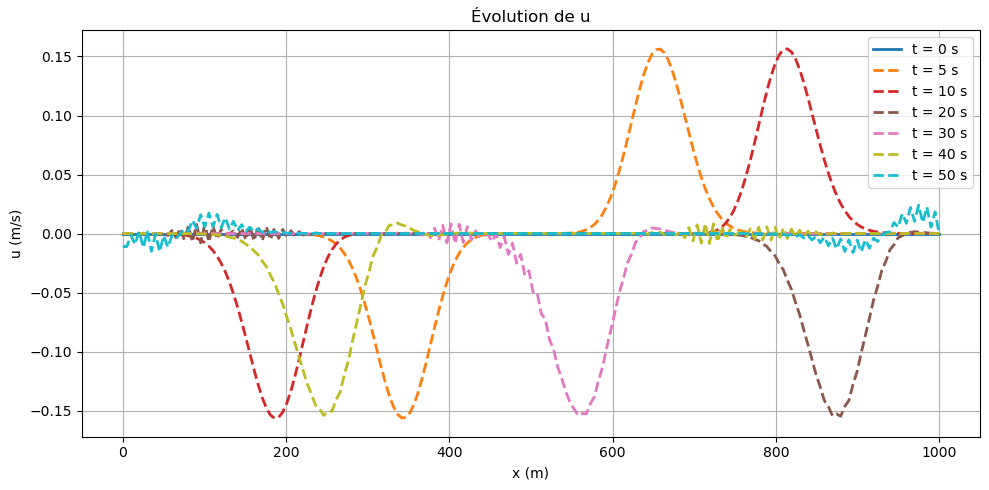

In [28]:
times_to_plot = [0, 5, 10, 20, 30, 40, 50] 

# Remplacement NaN / Inf pour affichage
eta_disp = np.nan_to_num(eta, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(10,5))
colors = plt.cm.tab10(np.linspace(0, 1, len(times_to_plot)))

for t_plot, col in zip(times_to_plot, colors):
    k = int(t_plot / dt)
    if k >= T:
        print(f"⚠️  Temps t={t_plot} s ignoré (hors simulation)")
        continue
    style = '-' if t_plot == 0 else '--'
    plt.plot(x, eta_disp[k, :],
             color=col,
             linestyle=style,
             linewidth=2,
             label=f"t = {t_plot:.0f} s")
plt.xlabel("x (m)")
plt.ylabel("η (m)")
plt.title("Évolution de η")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Remplacement NaN / Inf pour affichage
u_disp = np.nan_to_num(u, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(10,5))
colors = plt.cm.tab10(np.linspace(0, 1, len(times_to_plot)))
for t_plot, col in zip(times_to_plot, colors):
    k = int(t_plot / dt)
    if k >= T:
        print(f"⚠️  Temps t={t_plot} s ignoré (hors simulation)")
        continue
    style = '-' if t_plot == 0 else '--'
    plt.plot(x, u_disp[k, :],
             color=col,
             linestyle=style,
             linewidth=2,
             label=f"t = {t_plot:.0f} s")
plt.xlabel("x (m)")
plt.ylabel("u (m/s)")
plt.title("Évolution de u")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# On néglige eta devant H avec dt=0.01

In [34]:
T=6000
dt=0.01

# initializing 
eta = np.zeros([T , N])
u  = np.zeros([T , N])

# apply initial condition
eta[0,:] = eta_0
u[0,:] = u_0

for k in range(T-1):
    for i in range(1,N-1):
        du_dx    = (u[k,i+1] - u[k,i-1]) / (2*dx)
        deta_dx  = (eta[k,i+1] - eta[k,i-1]) / (2*dx)

        # mise à jour de u
        u[k+1,i] = u[k,i] - dt * (g*deta_dx)

        # mise à jour de eta
        eta[k+1,i] = eta[k,i] - (dt / (2*dx)) * ((H)*u[k,i+1] - (H)*u[k,i-1])

    u[k+1,0] = u[k+1,1]           # open ocean (absorbtion)
    u[k+1,N-1] = 0.0              # wall = coast (reflexion)
    eta[k+1,0] = eta[k+1,1]       # open ocean 
    eta[k+1,N-1] = eta[k+1,N-2]   # wall = coast

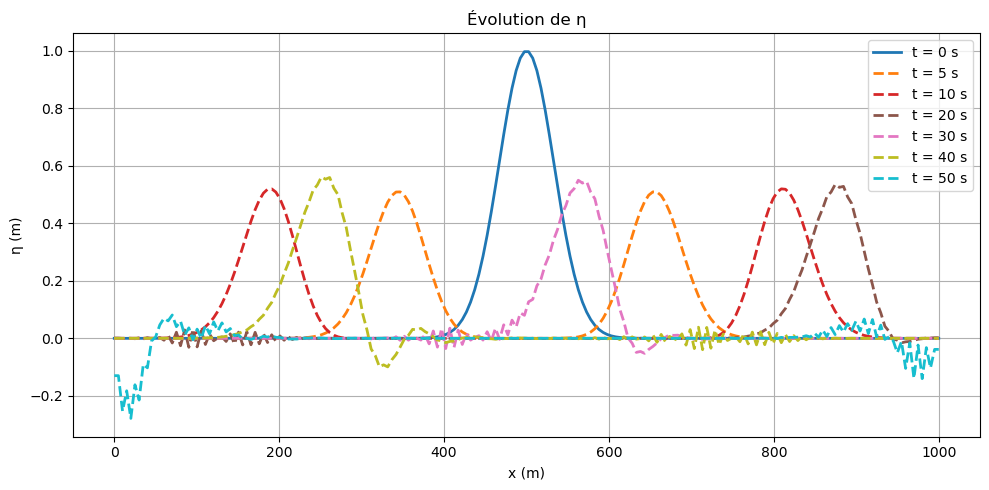

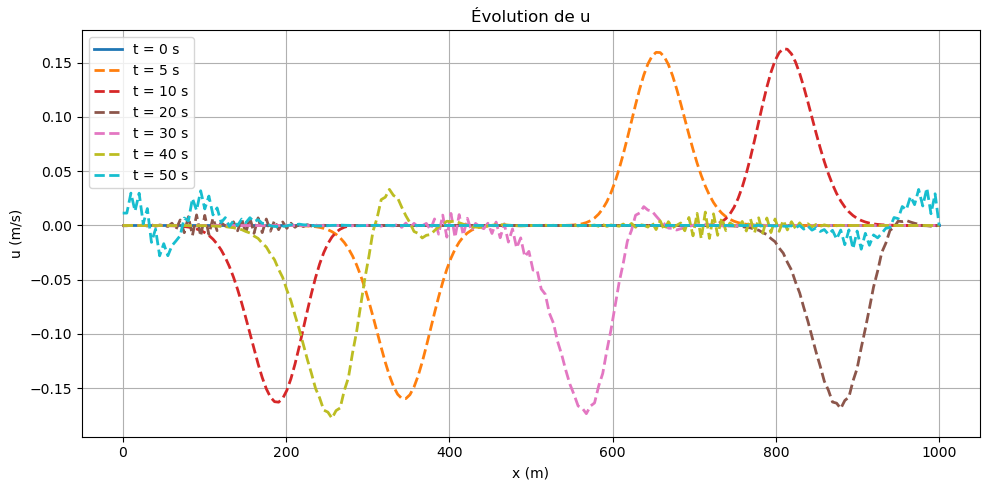

In [35]:
times_to_plot = [0, 5, 10, 20, 30, 40, 50] 

# Remplacement NaN / Inf pour affichage
eta_disp = np.nan_to_num(eta, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(10,5))
colors = plt.cm.tab10(np.linspace(0, 1, len(times_to_plot)))

for t_plot, col in zip(times_to_plot, colors):
    k = int(t_plot / dt)
    if k >= T:
        print(f"⚠️  Temps t={t_plot} s ignoré (hors simulation)")
        continue
    style = '-' if t_plot == 0 else '--'
    plt.plot(x, eta_disp[k, :],
             color=col,
             linestyle=style,
             linewidth=2,
             label=f"t = {t_plot:.0f} s")
plt.xlabel("x (m)")
plt.ylabel("η (m)")
plt.title("Évolution de η")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Remplacement NaN / Inf pour affichage
u_disp = np.nan_to_num(u, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(10,5))
colors = plt.cm.tab10(np.linspace(0, 1, len(times_to_plot)))
for t_plot, col in zip(times_to_plot, colors):
    k = int(t_plot / dt)
    if k >= T:
        print(f"⚠️  Temps t={t_plot} s ignoré (hors simulation)")
        continue
    style = '-' if t_plot == 0 else '--'
    plt.plot(x, u_disp[k, :],
             color=col,
             linestyle=style,
             linewidth=2,
             label=f"t = {t_plot:.0f} s")
plt.xlabel("x (m)")
plt.ylabel("u (m/s)")
plt.title("Évolution de u")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Pas de différence en négligeant tout ($\eta \ll H$, $u \frac{\partial u}{\partial x}$, $\nu \nabla^{2} u$), donc ça viendrait des conditions de bord (côté open ocean ? ou côté coast ?)

# Schéma d'Euler implicite (plus stable)

$$
\left(\frac{\partial u}{\partial t}\right)_i^k \approx \frac{u_{i}^{k} - u_{i}^{k-1}}{\Delta t} \Rightarrow u_{i}^{k} = u_{i}^{k-1} + \Delta t \left(\frac{\partial u}{\partial t}\right)_i^k
$$

$$
u_i^{k} = u_i^{k-1} - \Delta t \Big[ u_i^k \left(\frac{\partial u}{\partial x}\right)_i^k + g \left(\frac{\partial \eta}{\partial x}\right)_i^k - \nu \left(\frac{\partial^2 u}{\partial x^2}\right)_i^k \Big]
$$

$$
\eta_i^{k} = \eta_i^{k-1} - \frac{\Delta t}{2 \Delta x} \Big[ (H + \eta_{i+1}^k) u_{i+1}^k - (H + \eta_{i-1}^k) u_{i-1}^k \Big]
$$

In [9]:
T=6000
dt=0.01

# initializing 
eta = np.zeros([T , N])
u  = np.zeros([T , N])

# apply initial condition
eta[0,:] = eta_0
u[0,:] = u_0

for k in range(T-1):

    # --- Construction du système pour u^{k+1} et eta^{k+1} ---
    A = np.zeros((2*N, 2*N))   # matrice du système
    b = np.zeros(2*N)          # second membre

    # --- Équations internes ---
    for i in range(1, N-1):

        # Indices dans le vecteur X = [u(0..N-1), eta(0..N-1)]
        ui   = i
        etai = N + i

        # 1) Équation implicite pour u :
        # u_i^{k+1} - dt * g * (eta_{i+1}^{k+1} - eta_{i-1}^{k+1})/(2dx) = u_i^k

        A[ui, ui] = 1.0
        A[ui, etai+1] = -dt * g / (2*dx)
        A[ui, etai-1] =  dt * g / (2*dx)
        b[ui] = u[k,i]

        # 2) Équation implicite pour eta :
        # eta_i^{k+1} + dt*H*(u_{i+1}^{k+1} - u_{i-1}^{k+1})/(2dx) = eta_i^k

        A[etai, etai] = 1.0
        A[etai, ui+1] =  dt * H / (2*dx)
        A[etai, ui-1] = -dt * H / (2*dx)
        b[etai] = eta[k,i]

    # --- Conditions aux limites (implicites aussi) ---
    # u(0) = u(1)    (open ocean)
    A[0,0] = 1;  A[0,1] = -1;  b[0] = 0

    # u(N-1) = 0     (mur côtier)
    A[N-1, N-1] = 1;  b[N-1] = 0

    # eta(0) = eta(1)
    A[N, N] = 1;  A[N, N+1] = -1;  b[N] = 0

    # eta(N-1) = eta(N-2)
    A[2*N-1, 2*N-1] = 1; A[2*N-1, 2*N-2] = -1; b[2*N-1] = 0

    # --- Résolution du système linéaire ---
    X = np.linalg.solve(A, b)

    # --- Extraction ---
    u[k+1,:]   = X[:N]
    eta[k+1,:] = X[N:]

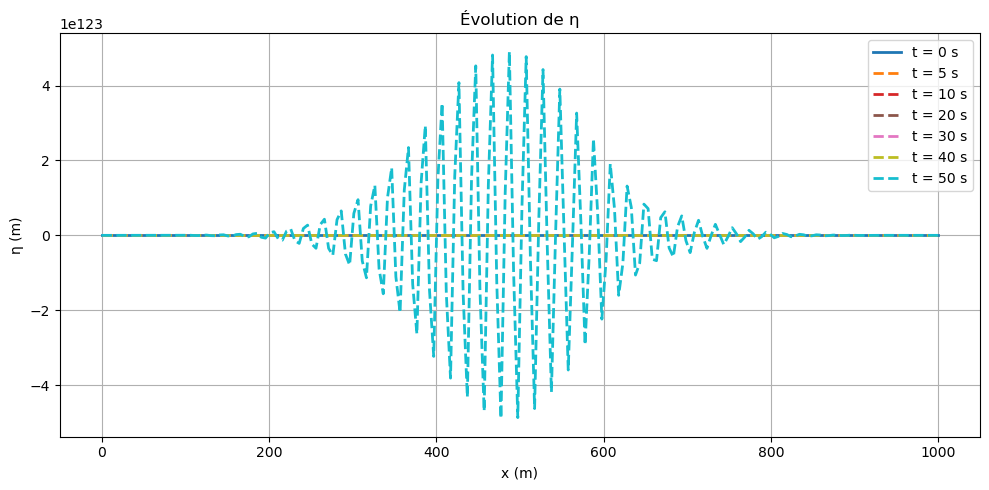

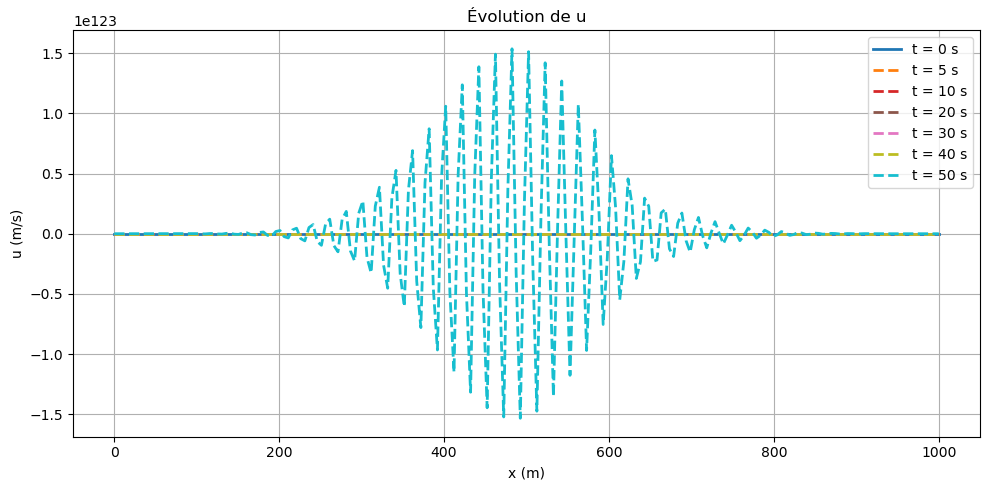

In [10]:
times_to_plot = [0, 5, 10, 20, 30, 40, 50] 

# Remplacement NaN / Inf pour affichage
eta_disp = np.nan_to_num(eta, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(10,5))
colors = plt.cm.tab10(np.linspace(0, 1, len(times_to_plot)))

for t_plot, col in zip(times_to_plot, colors):
    k = int(t_plot / dt)
    if k >= T:
        print(f"⚠️  Temps t={t_plot} s ignoré (hors simulation)")
        continue
    style = '-' if t_plot == 0 else '--'
    plt.plot(x, eta_disp[k, :],
             color=col,
             linestyle=style,
             linewidth=2,
             label=f"t = {t_plot:.0f} s")
plt.xlabel("x (m)")
plt.ylabel("η (m)")
plt.title("Évolution de η")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Remplacement NaN / Inf pour affichage
u_disp = np.nan_to_num(u, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(10,5))
colors = plt.cm.tab10(np.linspace(0, 1, len(times_to_plot)))
for t_plot, col in zip(times_to_plot, colors):
    k = int(t_plot / dt)
    if k >= T:
        print(f"⚠️  Temps t={t_plot} s ignoré (hors simulation)")
        continue
    style = '-' if t_plot == 0 else '--'
    plt.plot(x, u_disp[k, :],
             color=col,
             linestyle=style,
             linewidth=2,
             label=f"t = {t_plot:.0f} s")
plt.xlabel("x (m)")
plt.ylabel("u (m/s)")
plt.title("Évolution de u")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Rung kutta explicite ordre 4 

$k_1 = f(t_n, y_n)$

$k_2 = f\!\left(t_n + \frac{h}{2},\; y_n + \frac{h}{2} k_1\right)$

$k_3 = f\!\left(t_n + \frac{h}{2},\; y_n + \frac{h}{2} k_2\right)$

$k_4 = f\!\left(t_n + h,\; y_n + h\, k_3\right)$

$$
y_{n+1}
=
y_n
+
\frac{h}{6}
\left(
k_1
+
2k_2
+
2k_3
+
k_4
\right)
$$

$$
\frac{d}{dt}
\begin{pmatrix}
u \\
\eta
\end{pmatrix}
=
\begin{pmatrix}
-\,g\,\partial_x \eta \\
-\,H\,\partial_x u
\end{pmatrix}
$$

$$
y =
\begin{pmatrix}
u_1 \\
u_2 \\
\vdots \\
u_N \\
\eta_1 \\
\eta_2 \\
\vdots \\
\eta_N
\end{pmatrix}
$$

$$
f(t, y)
=
\begin{pmatrix}
-\,g\,\partial_x \eta \\
-\,H\,\partial_x u
\end{pmatrix}
$$

In [10]:
T=6000
dt=0.01

# initializing 
eta = np.zeros([T , N])
u  = np.zeros([T , N])

# apply initial condition
eta[0,:] = eta_0
u[0,:] = u_0

In [11]:
def dudt(u, eta, dx, g):
    N = len(u)
    du = np.zeros(N)
    for i in range(1, N-1):
        deta_dx = (eta[i+1] - eta[i-1]) / (2*dx)
        du[i] = -g * deta_dx
    # conditions aux bords
    du[0] = du[1]
    du[-1] = 0.0
    return du

def detadt(u, eta, dx, H):
    N = len(u)
    deta = np.zeros(N)
    for i in range(1, N-1):
        du_dx = (u[i+1] - u[i-1]) / (2*dx)
        deta[i] = -H * du_dx
    # conditions aux bords
    deta[0] = deta[1]
    deta[-1] = deta[-2]
    return deta

In [12]:
for k in range(T-1):
    # --- k1 ---
    k1_u   = dudt(u[k], eta[k], dx, g)
    k1_eta = detadt(u[k], eta[k], dx, H)

    # --- k2 ---
    u2   = u[k]   + 0.5 * dt * k1_u
    eta2 = eta[k] + 0.5 * dt * k1_eta
    k2_u   = dudt(u2, eta2, dx, g)
    k2_eta = detadt(u2, eta2, dx, H)

    # --- k3 ---
    u3   = u[k]   + 0.5 * dt * k2_u
    eta3 = eta[k] + 0.5 * dt * k2_eta
    k3_u   = dudt(u3, eta3, dx, g)
    k3_eta = detadt(u3, eta3, dx, H)

    # --- k4 ---
    u4   = u[k]   + dt * k3_u
    eta4 = eta[k] + dt * k3_eta
    k4_u   = dudt(u4, eta4, dx, g)
    k4_eta = detadt(u4, eta4, dx, H)

    # --- mise à jour finale ---
    u[k+1]   = u[k]   + (dt/6) * (k1_u + 2*k2_u + 2*k3_u + k4_u)
    eta[k+1] = eta[k] + (dt/6) * (k1_eta + 2*k2_eta + 2*k3_eta + k4_eta)

    # --- conditions aux bords ---
    u[k+1,0]  = u[k+1,1]       # open ocean
    u[k+1,-1] = 0.0            # wall/coast
    eta[k+1,0]  = eta[k+1,1]   # open ocean
    eta[k+1,-1] = eta[k+1,-2]  # wall/coast

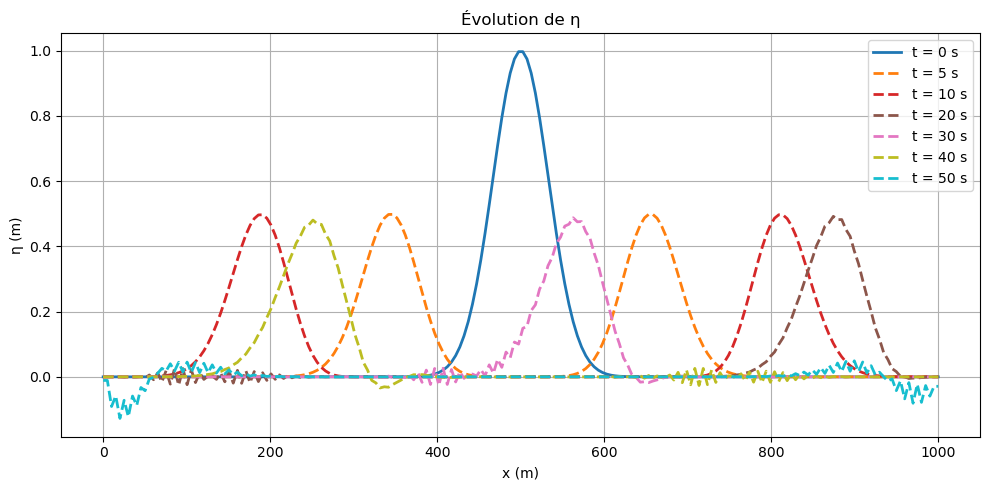

In [ ]:
times_to_plot = [0, 5, 10, 20, 30, 40, 50] 

# Remplacement NaN / Inf pour affichage
eta_disp = np.nan_to_num(eta, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(10,5))
colors = plt.cm.tab10(np.linspace(0, 1, len(times_to_plot)))

for t_plot, col in zip(times_to_plot, colors):
    k = int(t_plot / dt)
    if k >= T:
        print(f"⚠️  Temps t={t_plot} s ignoré (hors simulation)")
        continue
    style = '-' if t_plot == 0 else '--'
    plt.plot(x, eta_disp[k, :],
             color=col,
             linestyle=style,
             linewidth=2,
             label=f"t = {t_plot:.0f} s")
plt.xlabel("x (m)")
plt.ylabel("η (m)")
plt.title("Évolution de η")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Remplacement NaN / Inf pour affichage
u_disp = np.nan_to_num(u, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(10,5))
colors = plt.cm.tab10(np.linspace(0, 1, len(times_to_plot)))
for t_plot, col in zip(times_to_plot, colors):
    k = int(t_plot / dt)
    if k >= T:
        print(f"⚠️  Temps t={t_plot} s ignoré (hors simulation)")
        continue
    style = '-' if t_plot == 0 else '--'
    plt.plot(x, u_disp[k, :],
             color=col,
             linestyle=style,
             linewidth=2,
             label=f"t = {t_plot:.0f} s")
plt.xlabel("x (m)")
plt.ylabel("u (m/s)")
plt.title("Évolution de u")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Tester des conditions 